In [233]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from numpy.linalg import inv
from numpy import linalg as LA
import math
from random import sample
from scipy.optimize import least_squares
import glob
import BitVector
import numpy as np
import torch
import torch.nn as nn
from sklearn import svm
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})
import time

import torch
from torch import nn, optim
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from scipy.sparse.linalg import eigsh

# TASK 1: PCA, LDA
- read the image and do normalization
- use computation trick to get eigenvectors from SVD
- Choose the eigenvectors with the k largest eigenvalue as the feature vectors.
- Project the image onto the feature vectors.
- Use my nearest neigbor algorothm to classify the image
- For PCA, we extract feature vectors from covariance matrix
- For LDA, we extract feature vectors from that maximize between class scatter and minimize within class scatter

### From my implementation, LDA and PCA performs equally good. LDA performs a little bit better than PCA when feature number are small.

In [234]:
Path = 'F:/Python/Computer_Vision/HW10'

os.chdir('F:/Python/Computer_Vision/HW10')
Face_train = Path + '/FaceRecognition/train'
Face_test = Path + '/FaceRecognition/test'

In [235]:
# read the categories images
os.chdir(Face_train)
train_img = glob.glob('*.png')
train_img;

x_train = []
y_train = []

for i in train_img:
    y, _ = i.split('_')
    y = int(y)
    
    x = cv.imread(i)
    x_gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    x_vect = np.ravel(x_gray)
    x_norm = x_vect/np.linalg.norm(x_vect)
    
    x_train.append(x_norm)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)


os.chdir(Face_test)
test_img = glob.glob('*.png')
test_img;

x_test = []
y_test = []

for i in test_img:
    y, _ = i.split('_')
    y = int(y)
    
    x = cv.imread(i)
    x_gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    x_vect = np.ravel(x_gray)
    x_norm = x_vect/np.linalg.norm(x_vect)
    
    x_test.append(x_norm)
    y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [236]:
x_test.shape
y_test.shape

(630,)

In [237]:
# from train to eigenvectors
m = x_train.mean(axis = 0)
X = (x_train - m).T
C = X.T@X
_, eigen_val, eigen_vect = np.linalg.svd(C)
p = 10


eigen_vector = []
for i in range(p):
    vect = eigen_vect[i]
    vect = X@vect
    vect = vect/np.linalg.norm(vect)
    eigen_vector.append(vect)
eigen_vector = np.array(eigen_vector)

In [238]:
def eigen_feature_cal(x_train, p):
    m = x_train.mean(axis = 0)
    X = (x_train - m).T
    C = X.T@X
    _, eigen_val, eigen_vect = np.linalg.svd(C)
    

    # construct the final eigen vector
    eigen_vector = []
    for i in range(p):
        vect = eigen_vect[i]
        vect = X@vect
        vect = vect/np.linalg.norm(vect) # normalize again
        eigen_vector.append(vect)
    eigen_vector = np.array(eigen_vector)
    
    
    return eigen_vector

eigen_feature_cal(x_train, 10).shape

(10, 16384)

In [239]:
def PCA_feature_cal(x_train, p):
    m = x_train.mean(axis = 0)
    X = (x_train - m).T
    C = X.T@X
    _, eigen_val, eigen_vect = np.linalg.svd(C)
    

    # construct the final eigen vector
    eigen_vector = []
    for i in range(p):
        vect = eigen_vect[i]
        vect = X@vect
        vect = vect/np.linalg.norm(vect) # normalize again
        eigen_vector.append(vect)
    eigen_vector = np.array(eigen_vector)

    return eigen_vector.T, m

PCA_feature, mean_vect = PCA_feature_cal(x_train, 10)

In [240]:
x_train_vect = (PCA_feature.T @ (x_train - mean_vect).T).T

In [241]:
x_train_vect.shape

(630, 10)

In [242]:
m = x_test.mean(axis = 0)
x_test_vect = (PCA_feature.T @ (x_test - mean_vect).T).T

In [243]:
# before NN
x_train_vect, y_train;
x_test_vect, y_test;

In [244]:
def singleNN_predict(x_train_vect, y_train, x_test_vect_single):
    dist = [0]*len(x_train_vect);
    
    for i in range(len(dist)):
        dist[i] = np.linalg.norm(x_train_vect[i] - x_test_vect_single)
    
    # find the clost neigbor
    label_pos = np.argmin(dist)
    
    return y_train[label_pos]

singleNN_predict(x_train_vect, y_train, x_test_vect[0])    

1

Text(0.5, 1.0, 'PCA')

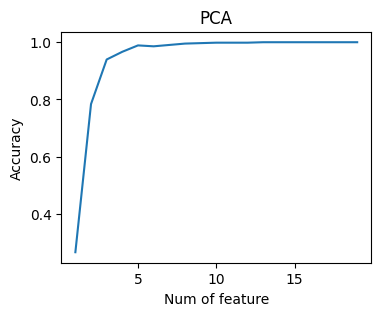

In [254]:
# calculate the accuracy
P_max = 20

PCA_accu = [0]*20

for p in range(1,len(PCA_accu)):
    
    PCA_feature, mean_vect = PCA_feature_cal(x_train, p)
    x_train_vect = (PCA_feature.T @ (x_train - mean_vect).T).T
    x_test_vect = (PCA_feature.T @ (x_test - mean_vect).T).T
    
    T_count = 0
    for i in range(len(x_test_vect)):
        if singleNN_predict(x_train_vect, y_train, x_test_vect[i]) == y_test[i]:
            T_count += 1
        
    PCA_accu[p] = T_count/len(x_test_vect)

plt.figure(figsize=(4, 3))   
plt.plot(range(1,P_max),PCA_accu[1:])
plt.xlabel('Num of feature')
plt.ylabel('Accuracy')
plt.title('PCA')

# LDA
- Calculate S_B and S_W matrix from trainig data
- Use the Yu and Yang algorithm to calculate the eigen vectors of inv(S_W)@ S_B

In [246]:
x_train, y_train;
m = x_train.mean(axis = 0)

# calculate S_B matrix with the trick
Classes = np.unique(y_train)
Classes_m = np.zeros((len(Classes),x_train.shape[1]))
S_W = np.zeros((x_train.shape[1],x_train.shape[1]))
S_B = np.zeros((x_train.shape[1],x_train.shape[1]))

for i in range(len(Classes)):
    c_data = x_train[y_train == Classes[i]]    
    Classes_m[i] = c_data.mean(axis = 0) 
    
    S_B_i = (1/len(Classes))*np.outer(Classes_m[i] - m,Classes_m[i] - m)
    S_B += S_B_i
    
    S_W_i = (1/len(Classes))*(1/len(c_data))*np.matmul((c_data-Classes_m[i]).T,(c_data-Classes_m[i]))
    S_W += S_W_i
    
X = Classes_m - m
_, eigen_val, eigen_vect = np.linalg.svd(X@X.T)

S_B_vect = []

for i in range(len(eigen_val)):
    if eigen_val[i] > 1e-3:
        S_B_vect.append(eigen_vect[i]/np.linalg.norm(eigen_vect[i]))

S_B_vect = (X.T @ (np.array(S_B_vect)).T).T

In [247]:
D_B = S_B_vect @ S_B @ S_B_vect.T
Z = S_B_vect.T @ inv(D_B)

D_W = Z.T@ S_W @ Z
_, eigen_val, eigen_vect = np.linalg.svd(D_W)

U = eigen_vect[::-1]
eigen_vect = (U @Z.T).T

Text(0.5, 1.0, 'LDA')

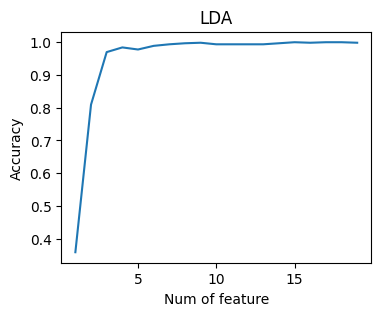

In [255]:
# LDA

P_max = 20

LDA_accu = [0]*20

for p in range(1,len(LDA_accu)):
    
    Classes_m;
    
    LDA_feature = eigen_vect[:,0:p]
    x_train_vect = (LDA_feature.T @ (x_train - m).T).T
    x_test_vect = (LDA_feature.T @ (x_test - m).T).T
    
    T_count = 0
    for i in range(len(x_test_vect)):
        if singleNN_predict(x_train_vect, y_train, x_test_vect[i]) == y_test[i]:
            T_count += 1
        
    LDA_accu[p] = T_count/len(x_test_vect)
    #print('Calculation ->', p)

plt.figure(figsize=(4, 3))
plt.plot(range(1,P_max),LDA_accu[1:])
plt.xlabel('Num of feature')
plt.ylabel('Accuracy')
plt.title('LDA')

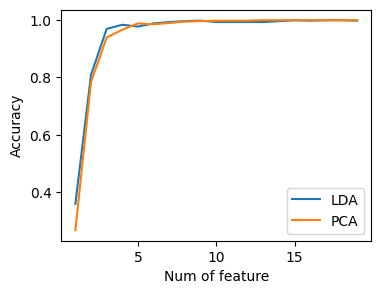

In [249]:
# compare
plt.figure(figsize=(4, 3))
plt.plot(range(1,P_max),LDA_accu[1:], label='LDA')
plt.plot(range(1,P_max),PCA_accu[1:], label='PCA')
plt.xlabel('Num of feature')
plt.ylabel('Accuracy')
plt.legend()

# TASK 2: Autoencoder
- Extract feature using Autoencoder
- Classifier with my own nearest neigbor algorithm
- The result are similar to the result from PCA and LDA

In [250]:
class DataBuilder(Dataset):
    def __init__(self, path):
        self.path = path
        self.image_list = [f for f in os.listdir(path) if f.endswith('.png')]
        self.label_list = [int(f.split('_')[0]) for f in self.image_list]
        self.len = len(self.image_list)
        self.aug = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        fn = os.path.join(self.path, self.image_list[index])
        x = Image.open(fn).convert('RGB')
        x = self.aug(x)
        return {'x': x, 'y': self.label_list[index]}

    def __len__(self):
        return self.len


class Autoencoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoded_space_dim = encoded_space_dim
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(True)
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(4 * 4 * 64, 128),
            nn.LeakyReLU(True),
            nn.Linear(128, encoded_space_dim * 2)
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.LeakyReLU(True),
            nn.Linear(128, 4 * 4 * 64),
            nn.LeakyReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(64, 4, 4))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        mu, logvar = x[:, :self.encoded_space_dim], x[:, self.encoded_space_dim:]
        return mu, logvar

    def decode(self, z):
        x = self.decoder_lin(z)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

    @staticmethod
    def reparameterize(mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)


class VaeLoss(nn.Module):
    def __init__(self):
        super(VaeLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, xhat, x, mu, logvar):
        loss_MSE = self.mse_loss(xhat, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return loss_MSE + loss_KLD


def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        mu, logvar = model.encode(data['x'])
        z = model.reparameterize(mu, logvar)
        xhat = model.decode(z)
        loss = vae_loss(xhat, data['x'], mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(trainloader.dataset)))


##################################
# Change these
p_list = [3, 8, 16] 
Auto_accu = []
for p in p_list:
    training = False
    TRAIN_DATA_PATH = 'F:/Python/Computer_Vision/HW10/FaceRecognition/train/'
    EVAL_DATA_PATH = 'F:/Python/Computer_Vision/HW10/FaceRecognition/test/'
    LOAD_PATH = f'F:/Python/Computer_Vision/HW10/weights/model_{p}.pt'
    OUT_PATH = 'F:/Python/Computer_Vision/HW10/autoencoder'
    ##################################

    model = Autoencoder(p)

    if training:
        epochs = 100
        log_interval = 1
        trainloader = DataLoader(
            dataset=DataBuilder(TRAIN_DATA_PATH),
            batch_size=12,
            shuffle=True,
        )
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        vae_loss = VaeLoss()
        for epoch in range(1, epochs + 1):
            train(epoch)
        torch.save(model.state_dict(), os.path.join(OUT_PATH, f'model_{p}.pt'))
    else:
        trainloader = DataLoader(
            dataset=DataBuilder(TRAIN_DATA_PATH),
            batch_size=1,
        )
        model.load_state_dict(torch.load(LOAD_PATH))
        model.eval()

        X_train, y_train = [], []
        for batch_idx, data in enumerate(trainloader):
            mu, logvar = model.encode(data['x'])
            z = mu.detach().cpu().numpy().flatten()
            X_train.append(z)
            y_train.append(data['y'].item())
        X_train = np.stack(X_train)
        y_train = np.array(y_train)

        testloader = DataLoader(
            dataset=DataBuilder(EVAL_DATA_PATH),
            batch_size=1,
        )
        X_test, y_test = [], []
        for batch_idx, data in enumerate(testloader):
            mu, logvar = model.encode(data['x'])
            z = mu.detach().cpu().numpy().flatten()
            X_test.append(z)
            y_test.append(data['y'].item())
        X_test = np.stack(X_test)
        y_test = np.array(y_test)

        ##################################
        # Your code starts here
        T_count = 0
        for i in range(len(x_test_vect)):
            if singleNN_predict(X_train, y_train, X_test[i]) == y_test[i]:
                T_count += 1

        Auto_accu.append(T_count/len(x_test_vect))
        
        ##################################

Text(0, 0.5, 'Accuracy')

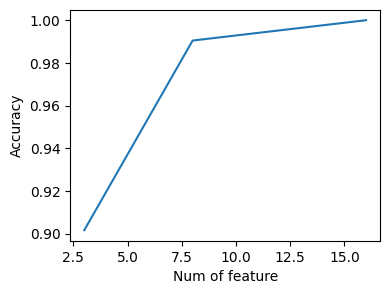

In [251]:
plt.figure(figsize=(4, 3))
plt.plot(p_list,Auto_accu)
plt.xlabel('Num of feature')
plt.ylabel('Accuracy')

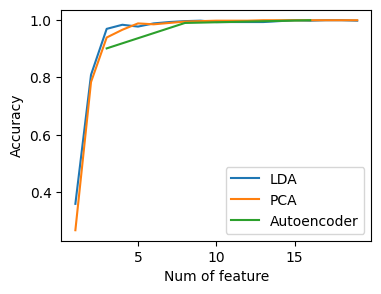

In [252]:
# compare
plt.figure(figsize=(4, 3))
plt.plot(range(1,P_max),LDA_accu[1:], label='LDA')
plt.plot(range(1,P_max),PCA_accu[1:], label='PCA')
plt.plot(p_list,Auto_accu, label='Autoencoder')
plt.xlabel('Num of feature')
plt.ylabel('Accuracy')
plt.legend()

# TASK 3: Object Detection using Cascaded AdaBoost Classifiers

- step1: extract features with harr filter
- For the strong classifier at each stage of the cascade, it has high TP rate and moderate FP rate.
- The strong classifier contains several weak classifiers.
- To construct strong classifier(H(x)) for each Cascade, find weak classifiers (h_t) that has the lowest mis-classification rate. 
- Adjust the weights after select each weak classifier, so that the next weak classifier focus on the misclassified result.
- Combine the result of weak classifiers, find the threshold with TP = 1 and small FP, stop when FP < FP_threshold. 
- For the next Cascade, set corrected classified negative weights to 0 (TN).


### Note
- In my implementation, I set postive as 1, negative as -1

### Main part that doesn't work

- The feature extractor doesn't work good, I can't find a threshold for each Cascade stage that makes TP=0 and FP small. It would be great if we can be provided with ways to extract the feature. I was trying to repeat the 2020 hw from Brain, but the method doesn't seems to work well.

### My expectation, if the code works, the FN should decrease to zero as we increase the stage number, its value can be infinite small.

### FP will increase as the stage number increases, as a side effect of increased FN. In real practice, we need to stop the program before FP become to large. 

### Even though my own Adaboost doesn't work, I use scikit learn to do Adaboost on the same data, the result is good -- shown at the end.

### step1: extract features with filter

In [305]:
# define a function to calculte feature from a gray scale image
def feature_extract(x_gray):
    H,W = x_gray.shape

    feature = []

    for i in range(1,H//2):
        kernel = np.array([[1]*i + [-1]*i]).T
        identity = cv.filter2D(src=x_gray, ddepth=cv.CV_64F, kernel=kernel)
        identity_vect = np.ravel(identity)
        feature.append(identity_vect)

#     for i in range(1,W//2):
#         kernel = np.array([[1]*i + [-1]*i])
#         identity = cv.filter2D(src=x_gray, ddepth=-1, kernel=kernel)
#         identity_vect = np.ravel(identity)
#         feature.append(identity_vect)

    feature = np.array(feature)
    feature = np.ravel(feature)
    
    return feature

In [306]:
# read image
Car_train = Path + '/CarDetection/train'
Car_train_P = Car_train + '/positive'
Car_train_N = Car_train + '/negative'

Car_test = Path + '/CarDetection/test'
Car_test_P = Car_test + '/positive'
Car_test_N = Car_test + '/negative'

x_train = []
x_test = []
y_train = []
y_test = []

os.chdir(Car_train_P)
train_img = glob.glob('*.png')

for i in train_img:
    
    x = cv.imread(i)
    x_gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    
    x_feature = feature_extract(x_gray)
    
    x_train.append(x_feature)
    y_train.append(1)
    
os.chdir(Car_train_N)
train_img = glob.glob('*.png')

for i in train_img:
    
    x = cv.imread(i)
    x_gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    x_feature = feature_extract(x_gray)
    
    x_train.append(x_feature)
    y_train.append(-1)
    
os.chdir(Car_test_N)
test_img = glob.glob('*.png')

for i in test_img:
    
    x = cv.imread(i)
    x_gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    x_feature = feature_extract(x_gray)
    
    x_test.append(x_feature)
    y_test.append(-1)    

    
os.chdir(Car_test_P)
test_img = glob.glob('*.png')

for i in test_img:
    
    x = cv.imread(i)
    x_gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    x_feature = feature_extract(x_gray)
    
    x_test.append(x_feature)
    y_test.append(1)  

x_test = np.array(x_test)
x_train = np.array(x_train)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [297]:
# from img to feature
x_gray
H,W = x_gray.shape

feature = []

for i in range(1,H//2):
    kernel = np.array([[1]*i + [-1]*i]).T
    print(kernel.T)
    identity = cv.filter2D(src=x_gray, ddepth= cv.CV_64F, kernel=kernel)
#     print(identity.shape)
    identity_vect = np.ravel(identity)
    feature.append(identity_vect)
    
for i in range(1,W//2):
    kernel = np.array([[1]*i + [-1]*i])
    identity = cv.filter2D(src=x_gray, ddepth=-1, kernel=kernel)
    identity_vect = np.ravel(identity)
    feature.append(identity_vect)

feature = np.array(feature)
feature = np.ravel(feature)
feature.shape

[[ 1 -1]]
[[ 1  1 -1 -1]]
[[ 1  1  1 -1 -1 -1]]
[[ 1  1  1  1 -1 -1 -1 -1]]
[[ 1  1  1  1  1 -1 -1 -1 -1 -1]]
[[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]]
[[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]]
[[ 1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[ 1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


(22400,)

In [276]:
x_train.shape, x_gray.shape

((2468, 22400), (20, 40))

# weak classifier


3418 1 85.0 357 0.17933951833870243


0.043031930923461914

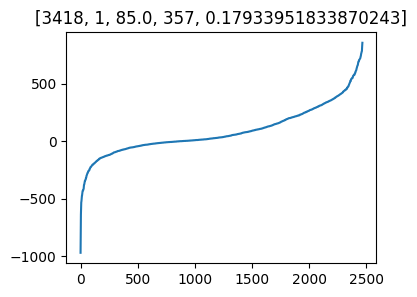

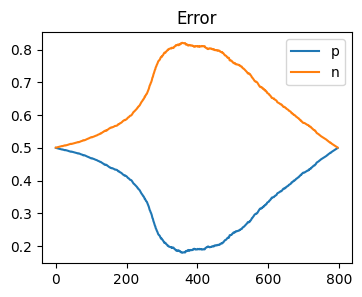

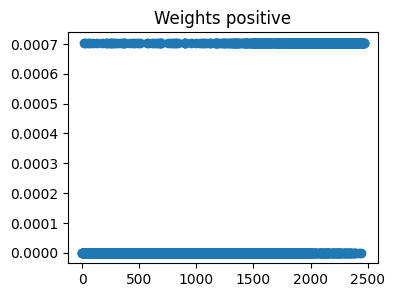

In [319]:
# search for the best weak classifier
time_b = time.time()
x_train, y_train;

# initial set 
weights = np.ones(len(y_train))
weights[y_train == 1] = 0.5*1/(y_train==1).sum()
weights[y_train == -1] =0.5*1/(y_train==-1).sum()
# weights = np.random.rand(len(y_train))

clf_best = None
err_best = np.inf
loss = [0]*x_train[0]
for i in range(3418, 3419):#len(x_train[0])
    feature = x_train[:,i]
    # speed up by sorting
    Sort = np.array([feature, y_train.T, weights.T]).T
    Sort = list(Sort)
    Sort.sort(key=lambda x: x[0])
    Sort = np.array(Sort)
    # feature, label, weights
    f, l, w = Sort.T
    
    T_n = np.sum(w[l == -1])
    T_p = np.sum(w[l == 1])
    
    # get the pos weights and negative weights
    weights_p = w.copy()
    weights_p[l==-1] = 0
    weights_n = w.copy()
    weights_n[l==1] = 0
    
    # cumsum to avoid third loop, x_axis should be distinct feature value 
    # unique value and position
    pos_list = []
    unique_list = np.unique(f)
    pos_u = 1
    while pos_u < len(f):
        if f[pos_u-1] < f[pos_u]:
            pos_list.append(pos_u-1)            
        pos_u += 1
        
    weights_p_c = np.cumsum(weights_p)
    weights_n_c = np.cumsum(weights_n)
    
    # smaller error is aimed
#     err_p = weights_p_c[pos_list] + np.array([T_n]*len(pos_list)) - weights_n_c[pos_list] # always positive
#     err_n = weights_n_c[pos_list] + np.array([T_p]*len(pos_list)) - weights_p_c[pos_list]
    err_p = weights_p_c[pos_list] + T_n - weights_n_c[pos_list] # always positive
    err_n = weights_n_c[pos_list] + T_p - weights_p_c[pos_list]

    err_p_min = min(err_p)
    err_n_min = min(err_n)
    err_min = min(err_p_min, err_n_min)
    
    # update the best clf
    if err_min < err_best:
        err_best = err_min
        
        if err_p_min < err_n_min:
            polar = 1
            threshold = unique_list[np.argmin(err_p)]
            threshold_pos = np.argmin(err_p)
#             res = feature >= threshold
        else:
            polar = -1
            threshold = unique_list[np.argmin(err_n)]
            threshold_pos = np.argmin(err_n)
#             res = feature <= threshold
    
        clf_best = [i, threshold, polar, err_min, res]
    
        print(i, polar, threshold,threshold_pos, err_min)

    y_pred = np.ones(y_train.shape)
    if polar==1:
        y_pred[feature < threshold] = -1
    else:
        y_pred[feature > threshold] = -1
        
    tn, fp, fn, tp = confusion_matrix((y_train+1)//2, (y_pred+1)//2).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    loss[i] = 1- (tp+tn)/(tn+ fp+ fn+ tp)

    
    plt.figure(figsize=(4, 3))
    plt.plot(f)
    plt.title([i, polar, threshold,threshold_pos, err_min])
    
    plt.figure(figsize=(4, 3))
    plt.plot(err_p, label = 'p')
    plt.plot(err_n, label = 'n')
    plt.legend()
    plt.title('Error')
    
    plt.figure(figsize=(4, 3))
    plt.scatter(range(len(weights_p)),weights_p)
    plt.title('Weights positive')
    
# feature.shape   
time_e = time.time()
time_e - time_b
#plt.plot(loss)

# implementation of Adaboost

In [314]:
# program to adjust weigths after each cascade
def weight_adjust_cascade(weights, y_pred, y_train):
    weights_new = weights.copy()
    for i in range(len(y_pred)):
        if y_pred[i]==-1 and y_train[i]==-1:
            weights[i] = 0
    return weights_new

def confidence(error):
    beta = error/(1-error)
    alpha = 0.5*np.log(1/beta)
    return alpha

def updata_weight(weight_old, alpha, label_true, label_pred):
    weight_new = weights * np.exp(- alpha * y_train * y_pred)/(weights * np.exp(- alpha * y_train * y_pred)).sum()
    return weight_new

In [312]:
# program to build the weak classifier
def weak_classifier(x_train, y_train, weights, Model, feature_selected):
    
    clf_best = None
    err_best = np.inf

    for i in range(len(x_train[0])):#len(x_train[0])
        
        # ignore the feature already have
        if i not in feature_selected:


            feature = x_train[:,i]
            # speed up by sorting
            Sort = np.array([feature, y_train.T, weights.T]).T
            Sort = list(Sort)
            Sort.sort(key=lambda x: x[0])
            Sort = np.array(Sort)
            # feature, label, weights
            f, l, w = Sort.T

            T_n = np.sum(w[l == -1])
            T_p = np.sum(w[l == 1])

            # get the pos weights and negative weights
            weights_p = w.copy()
            weights_p[l==-1] = 0
            weights_n = w.copy()
            weights_n[l==1] = 0

            # cumsum to avoid third loop, x_axis should be distinct feature value 
            # unique value and position
            pos_list = []
            unique_list = np.unique(f)
            pos_u = 1
            
            while pos_u < len(f):
                if f[pos_u-1] < f[pos_u]:
                    pos_list.append(pos_u-1)            
                pos_u += 1

            weights_p_c = np.cumsum(weights_p)
            weights_n_c = np.cumsum(weights_n)

            # smaller error is aimed
            err_p = weights_p_c[pos_list] + T_n - weights_n_c[pos_list] # always positive
            err_n = weights_n_c[pos_list] + T_p - weights_p_c[pos_list]

            err_p_min = min(err_p)
            err_n_min = min(err_n)
            err_min = min(err_p_min, err_n_min)

            # update the best clf
            if err_min < err_best:
                err_best = err_min

                if err_p_min < err_n_min:
                    polar = 1
                    threshold = unique_list[np.argmin(err_p)]
                    threshold_pos = np.argmin(err_p)
                else:
                    polar = -1
                    threshold = unique_list[np.argmin(err_n)]
                    threshold_pos = np.argmin(err_n)

                clf_best = [i, threshold, polar]

#             print(i, polar, threshold,threshold_pos, err_min)

    i, threshold, polar = clf_best
    # the best feature is chosen
    # adjust the threshold to get a high P rate
    feature = x_train[:,i]
        
    y_pred = np.ones(y_train.shape)
    if polar == 1:
        y_pred[feature < threshold] = -1
    else:
        y_pred[feature > threshold] = -1
         
    tn, fp, fn, tp = confusion_matrix((y_train+1)//2, (y_pred+1)//2).ravel()
    

    
    err_model = 1-(tp+tn)/(tn + fp + fn + tp)
    alpha = confidence(err_model)
    clf_select = [i, threshold, polar,alpha]
    weights_new = updata_weight(weights, alpha, y_train, y_pred)
    
    #     Model = np.append(Model, np.array(clf_best))
    Model.append(clf_select)
    feature_selected.append(i)
    
    print('\n loss is', err_model)
    print('\n TPR is', tp/(tp+fn) )
    print('\n FPR is', fp/(fp+tn) ,'\n')
    
    return Model, weights_new, feature_selected

# program to adjust the threshold for each cascade
def cascade_dec(x_train, y_train, Model):
    
    predictor_all = np.zeros(y_train.shape)
    for weak in Model:
#         predictor = np.ones(y_train.shape)
        feature_pos , threshold, p, alpha = weak
        feature = x_train[:,feature_pos]
        predictor = p*(feature-threshold)*alpha

#         predictor[feature*p < threshold*p] = -1
        predictor_all += predictor*alpha
    
    # doesn't make sense, as long as there is one misclassificaion, this won't work
    pred_threshold = (predictor_all[y_train == 1]).min()  
    y_pred =  np.ones(y_train.shape)
    y_pred[predictor_all<pred_threshold] = -1

    tn, fp, fn, tp = confusion_matrix((y_train+1)//2, (y_pred+1)//2).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)

    print('\n cascade TPR is', tpr )
    print('\n cascade FPR is', fpr ,'\n')
    return tpr,fpr,y_pred 

In [225]:
(tp+tn)/(tn + fp + fn + tp)

0.997163695299838

In [313]:
# the full adaboost program
Model = []
feature_selected = []
weights = np.ones(len(y_train))
weights[y_train == 1]  = 0.5*1/(y_train==1).sum()
weights[y_train == -1] = 0.5*1/(y_train==-1).sum()

for i in range(10):
    Model, weights_new, feature_selected = weak_classifier(x_train, y_train, weights, Model, feature_selected)
    weights = weights_new
    tpr, fpr , y_pred = cascade_dec(x_train, y_train, Model)
    
    print(i, 'th iteration -> \n', Model[-1])
    
    # break condition
    if fpr < 0.5:
        break


 loss is 0.1766612641815235

 TPR is 0.8436619718309859

 FPR is 0.18486916951080773 


 cascade TPR is 1.0

 cascade FPR is 0.9738339021615472 

0 th iteration -> 
 [3419, 106.0, 1, 0.769566782674669]

 loss is 0.24027552674230146

 TPR is 0.9309859154929577

 FPR is 0.3094425483503982 


 cascade TPR is 1.0

 cascade FPR is 0.9357224118316269 

1 th iteration -> 
 [5060, 71.0, 1, 0.5755847697033929]

 loss is 0.21758508914100483

 TPR is 0.5154929577464789

 FPR is 0.10978384527872583 


 cascade TPR is 1.0

 cascade FPR is 0.891353811149033 

2 th iteration -> 
 [7188, -44.0, -1, 0.6398975939598249]

 loss is 0.22690437601296598

 TPR is 0.22816901408450704

 FPR is 0.006825938566552901 


 cascade TPR is 1.0

 cascade FPR is 0.9709897610921502 

3 th iteration -> 
 [6221, -762.0, -1, 0.6129370341395184]

 loss is 0.23014586709886553

 TPR is 0.2056338028169014

 FPR is 0.0022753128555176336 


 cascade TPR is 1.0

 cascade FPR is 0.9829351535836177 

4 th iteration -> 
 [5419, -79

# Try to implement the AdaBoost classifier with scikit learn

### For training: FP = FN = 0
### For testing: FP = 0.048, FN = 0.049

In [170]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [172]:
clf.score(x_train, y_train)

1.0

In [174]:
# training result

y_pred = clf.predict(x_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
confusion_matrix(y_train, y_pred)

array([[1758,    0],
       [   0,  710]], dtype=int64)

In [175]:
# test result
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[432,   8],
       [ 22, 156]], dtype=int64)

Text(0.5, 1.0, 'accuracy vs stage number')

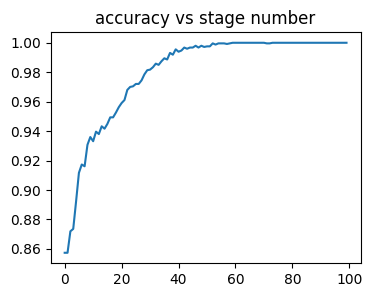

In [177]:
score = clf.staged_score(x_train,y_train)
score_stage = list(score)
plt.figure(figsize=(4, 3))
plt.plot(score_stage)
plt.title('accuracy vs stage number')

In [181]:
feature_list;

In [185]:
clf.staged_decision_function

<bound method AdaBoostClassifier.staged_decision_function of AdaBoostClassifier(n_estimators=100, random_state=0)>

In [113]:
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 100,
 'random_state': 0}

### Reduce the stage number to 50 -- no much change

In [198]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
clf = AdaBoostClassifier(n_estimators=50, random_state=0)
clf.fit(x_train, y_train)

AdaBoostClassifier(random_state=0)

In [199]:
# training result
y_pred = clf.predict(x_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
confusion_matrix(y_train, y_pred)

array([[1755,    3],
       [   4,  706]], dtype=int64)

In [200]:
# test result
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[425,  15],
       [ 19, 159]], dtype=int64)